<a href="https://colab.research.google.com/github/rajiv7654/C-programming-codes-with-uniqueness/blob/main/gpt_llm_trainer_v2%2C_with_GPT_3_5_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit-learn pandas numpy matplotlib seaborn

In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)

data = {
    "login_hour": np.random.randint(0, 24, 1000),
    "failed_logins": np.random.poisson(1, 1000),
    "files_accessed": np.random.randint(1, 50, 1000),
    "admin_commands": np.random.binomial(5, 0.1, 1000)
}

df = pd.DataFrame(data)
df.head()

,login_hour,failed_logins,files_accessed,admin_commands
0,6,0,6,1
1,19,1,7,0
2,14,1,32,1
3,10,1,32,1
4,7,0,25,0


In [3]:
from sklearn.ensemble import IsolationForest

# Define feature set explicitly
features = ["login_hour", "failed_logins", "files_accessed", "admin_commands"]

X = df[features]

uba_model = IsolationForest(contamination=0.05, random_state=42)

# Train + predict anomalies
df["anomaly"] = uba_model.fit_predict(X)

# Calculate risk score using SAME features
df["risk_score"] = -uba_model.score_samples(X)

df.head()


,login_hour,failed_logins,files_accessed,admin_commands,anomaly,risk_score
0,6,0,6,1,1,0.514234
1,19,1,7,0,1,0.494970
2,14,1,32,1,1,0.461860
3,10,1,32,1,1,0.458741
4,7,0,25,0,1,0.474674


In [4]:
# Attack type labels
# 0 = Normal
# 1 = Brute Force
# 2 = Privilege Escalation
# 3 = Data Exfiltration (simulated)

df["attack_type"] = 0  # default: normal behavior

# Brute Force: many failed logins
df.loc[df["failed_logins"] > 5, "attack_type"] = 1

# Privilege Escalation: excessive admin commands
df.loc[df["admin_commands"] > 3, "attack_type"] = 2

# Data Exfiltration: abnormal file access + anomaly
df.loc[
    (df["files_accessed"] > 40) & (df["anomaly"] == -1),
    "attack_type"
] = 3

df["attack_type"].value_counts()


,count
attack_type,
0,980
3,20


In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Feature set (same core behavior features)
features = ["login_hour", "failed_logins", "files_accessed", "admin_commands", "risk_score"]

X = df[features]
y = df["attack_type"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Train classifier
attack_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

attack_model.fit(X_train, y_train)

# Predictions
y_pred = attack_model.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       294
           3       1.00      1.00      1.00         6

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300


Confusion Matrix:

[[294   0]
 [  0   6]]


In [6]:
# Predict attack type for ALL events
df["predicted_attack"] = attack_model.predict(df[features])

# Optional: prediction confidence
df["attack_confidence"] = attack_model.predict_proba(df[features]).max(axis=1)


def generate_alert(row):
    if row["predicted_attack"] != 0 and row["risk_score"] > 0.7:
        return "CRITICAL"
    elif row["predicted_attack"] != 0 and row["risk_score"] > 0.5:
        return "HIGH"
    elif row["risk_score"] > 0.3:
        return "MEDIUM"
    else:
        return "LOW"


df["alert_level"] = df.apply(generate_alert, axis=1)

df["alert_level"].value_counts()


,count
alert_level,
MEDIUM,980
HIGH,20


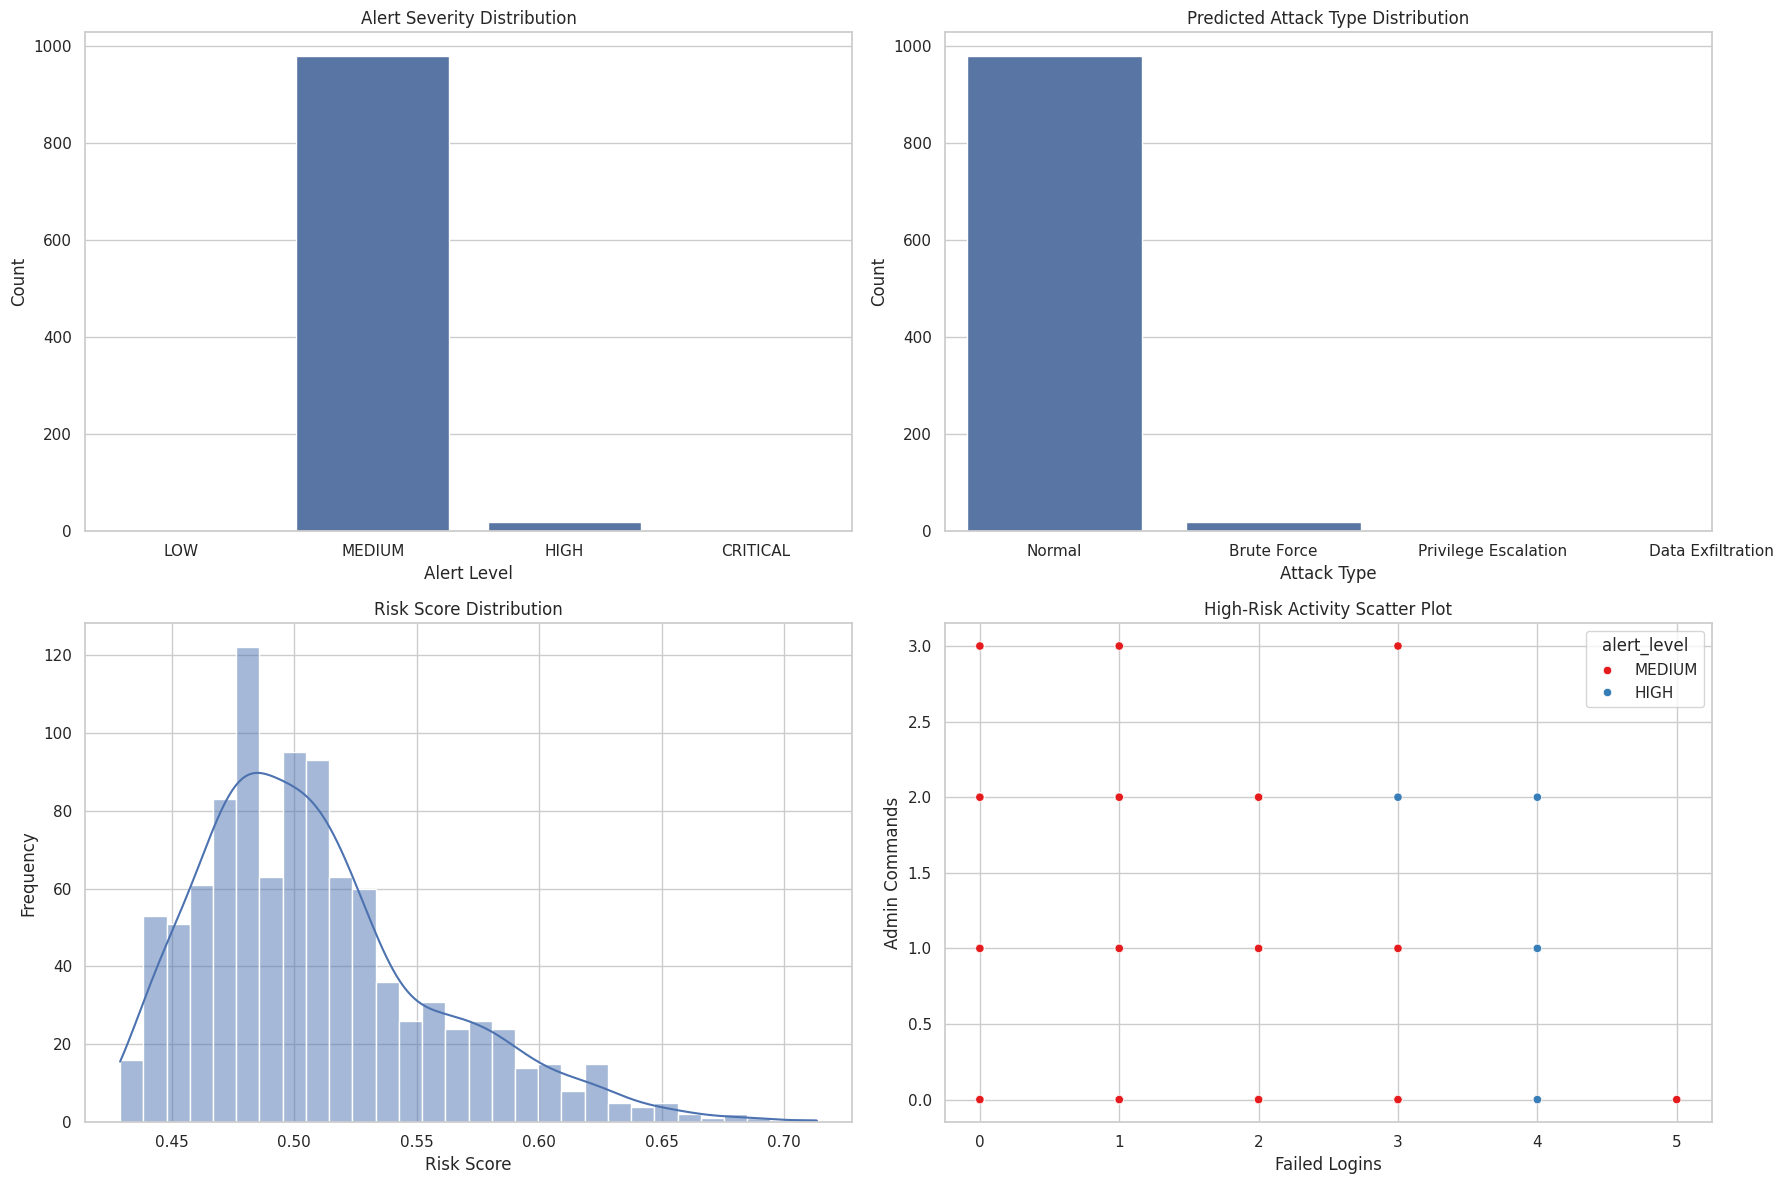

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(18, 12))

# -----------------------------
# 1️⃣ Alert Severity Distribution
# -----------------------------
plt.subplot(2, 2, 1)
sns.countplot(
    x="alert_level",
    data=df,
    order=["LOW", "MEDIUM", "HIGH", "CRITICAL"]
)
plt.title("Alert Severity Distribution")
plt.xlabel("Alert Level")
plt.ylabel("Count")

# -----------------------------
# 2️⃣ Attack Type Distribution
# -----------------------------
plt.subplot(2, 2, 2)
sns.countplot(x="predicted_attack", data=df)
plt.title("Predicted Attack Type Distribution")
plt.xlabel("Attack Type")
plt.ylabel("Count")

# Attack type legend
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=[
        "Normal",
        "Brute Force",
        "Privilege Escalation",
        "Data Exfiltration"
    ]
)

# -----------------------------
# 3️⃣ Risk Score Distribution
# -----------------------------
plt.subplot(2, 2, 3)
sns.histplot(df["risk_score"], bins=30, kde=True)
plt.title("Risk Score Distribution")
plt.xlabel("Risk Score")
plt.ylabel("Frequency")

# -----------------------------
# 4️⃣ High-Risk Events Scatter
# -----------------------------
plt.subplot(2, 2, 4)
sns.scatterplot(
    x="failed_logins",
    y="admin_commands",
    hue="alert_level",
    data=df,
    palette="Set1"
)
plt.title("High-Risk Activity Scatter Plot")
plt.xlabel("Failed Logins")
plt.ylabel("Admin Commands")

plt.tight_layout()
plt.show()


In [8]:
training_examples = [
    {
        "features": [10, 8, 20, 1, 0.75],
        "label": 1  # Brute Force
    },
    {
        "features": [22, 0, 10, 0, 0.15],
        "label": 0  # Normal
    },
    {
        "features": [3, 1, 45, 4, 0.88],
        "label": 2  # Privilege Escalation
    }
]

In [9]:
import numpy as np

X_explicit = np.array([ex["features"] for ex in training_examples])
y_explicit = np.array([ex["label"] for ex in training_examples])

In [10]:
explicit_model = RandomForestClassifier(n_estimators=100, random_state=42)
explicit_model.fit(X_explicit, y_explicit)

RandomForestClassifier(random_state=42)